# Some Synthetic Experiments
This notebook implement the uncertainty quantification method from the paper "Inference and uncertainty quantification for noisy matrix completion" https://arxiv.org/abs/2107.12365


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../cmc')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import logging

#### The functions created for our project

In [4]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from inference_function import *   # constructing the confidence intervals using the algorithm from the paper
from conformalize_chen import *

## Data generation in original paper

In [5]:
# Data generating functions
def generate_fixed_matrix(n1, n2, r, kappa=1):
    U_truth = orth(np.random.randn(n1, r))
    V_truth = orth(np.random.randn(n2, r))
    S_truth = np.diag(np.linspace(1, kappa, r))
    M = U_truth @ S_truth @ V_truth.T
    M = M / np.std(M)
    return M

def generate_noise(n1, n2, sigma, df="inf"):
    if df=="inf":
        E = np.random.normal(0, sigma, (n1, n2))
    else:
        E = sigma * np.random.standard_t(df, (n1, n2))
    return E

# Data generation
n1 = 100
n2 = 100
r = 5
p = 0.4
sigma = 1
kappa = 1
np.random.seed(1)



M = generate_fixed_matrix(n1, n2, r, kappa=kappa)  # M is rescaled with std(M)=1
E = generate_noise(n1, n2, sigma)

A = (np.random.rand(n1, n2) < p).astype(int)
M_obs = (M + E) * A

## Run the confidence interval constructed by the inference paper (Chen et al.)

In [6]:
alpha = 0.1

### Nonconvex method

In [7]:
CI_left, CI_right = CI_method(M_obs, A, r, alpha, method='ncvx')

# check
inside_CI = (M < CI_right) & (M > CI_left)
print(np.mean(inside_CI))  # if around (1-alpha), then good

#compute CI length
CI_length = CI_right - CI_left
print("Average CI Length:", CI_length.mean())

0.834
Average CI Length: 1.6821981694125852


### Convex Method

In [8]:
CI_left, CI_right = CI_method(M_obs, A, r, alpha, method='cvx')

# check
inside_CI = (M < CI_right) & (M > CI_left)
print(np.mean(inside_CI))  # if around (1-alpha), then good

#compute CI length
CI_length = CI_right - CI_left
print("Average CI Length:", CI_length.mean())

0.8305
Average CI Length: 1.680930255017741


# Plot the average coverage

## Experiment with fixed ground matrix and resampled masks
The ground truth noisy matrix is kept same for all repetition and the mask matrix is resampled at each iteration.

### Nonconvex method

In [9]:
# Data generation
n1 = 100
n2 = 100
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
np.random.seed(1)

M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
E = generate_noise(n1, n2, sigma)
M_true = M + E

In [10]:
repetition = 10
alpha = 0.1
random_state = 1

results = []

for i in tqdm(range(repetition)):
    mask = (np.random.rand(n1, n2) < p).astype(int)
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=mask, r=r, alpha=alpha, 
                                                    method='ncvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    results.append({"Coverage": result_coverage, "Size": result_length})
    
results_df = pd.DataFrame(results)

100%|██████████| 10/10 [00:00<00:00, 14.30it/s]


#### Plot the average coverage and the length of confidence intervals

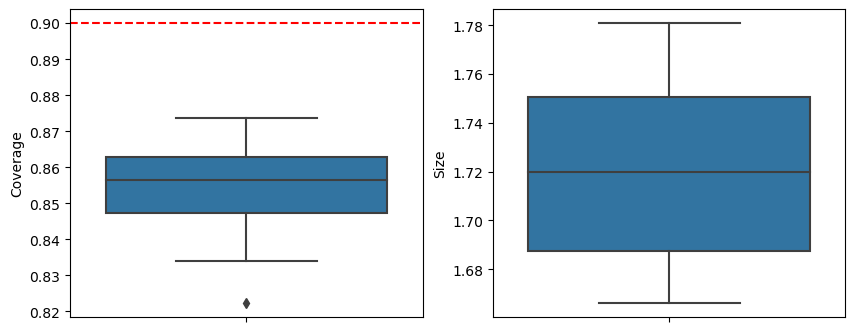

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_df, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_df, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

## Experiments with everything resampled every iteration

### Use a different rank for matrix completion (nonconvex)

In [12]:
# Data generation
n1 = 100
n2 = 100
r_true = 5
r_guess = 4
p = 0.4 #proportion of observed
sigma = 0.001
kappa = 1

In [13]:
#nonconvex method
repetition = 100
alpha = 0.1
random_state = 42

results = []

for i in tqdm(range(repetition)):
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma)
    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)
    
    M_true = M + E
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=A, r=r_guess, alpha=alpha, method='ncvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    results.append({"Coverage": result_coverage, "Size": result_length})
    
results_df = pd.DataFrame(results)

100%|██████████| 100/100 [00:08<00:00, 12.11it/s]


In [14]:
# Convex method
results = []

for i in tqdm(range(repetition)):
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma)
    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)
    
    M_true = M + E
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=A, r=r_guess, alpha=alpha, method='cvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    results.append({"Coverage": result_coverage, "Size": result_length})
    
results_df_cvx = pd.DataFrame(results)

100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


Nonconvex


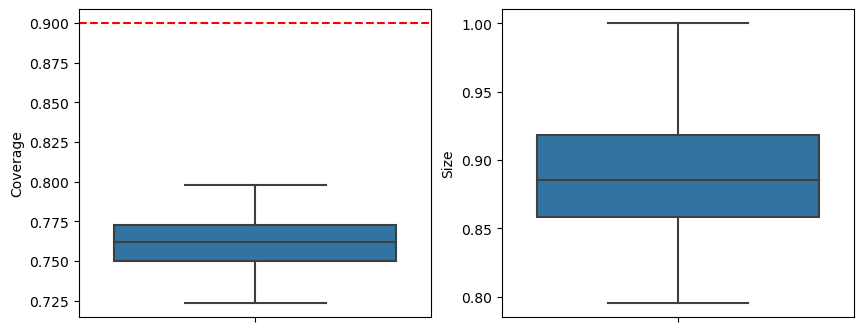



Convex


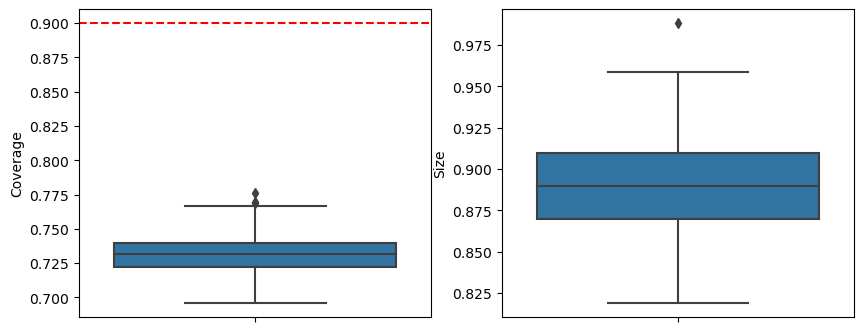

In [15]:
print('Nonconvex')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_df, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_df, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

print('\n'+'='*70+'\n')
print('Convex')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_df_cvx, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_df_cvx, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

# Experiments with varying matrix sizes

In [16]:
# Fixed parameters
r_true = 5
r_guess = 5
p = 0.5        #proportion of observed
sigma = 1
kappa = 1
alpha = 0.1

# Varying parameters
n_list = [100,200,300]

def run_experiment(n, seed, method = 'ncvx'):
    # default method is nonconvex
    # Parameters for this experiment
    n1 = n
    n2 = n
    
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma)
    M_true = M + E

    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)    
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=A, r=r_guess, alpha=alpha, 
                                                    method=method)
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    res = pd.DataFrame({"n":[n], "Seed":[seed], "Coverage": [result_coverage], "Size": [result_length]})
    return res

repetition = 10
results = pd.DataFrame({})
for seed in tqdm(range(repetition)):
    for n in n_list:
        res_new = run_experiment(n, seed, method = 'cvx')
        results = pd.concat([results, res_new])

100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


In [17]:
summary = results.groupby(['n']).agg({'Seed':['count'],'Coverage':[np.mean,np.std], 'Size':[np.mean,np.std]}).reset_index()
summary

n  Seed  Coverage                Size          
       count      mean       std      mean       std
0  100    10  0.848060  0.009652  1.442049  0.022408
1  200    10  0.867465  0.004357  1.003189  0.005365
2  300    10  0.877639  0.005707  0.823680  0.001902

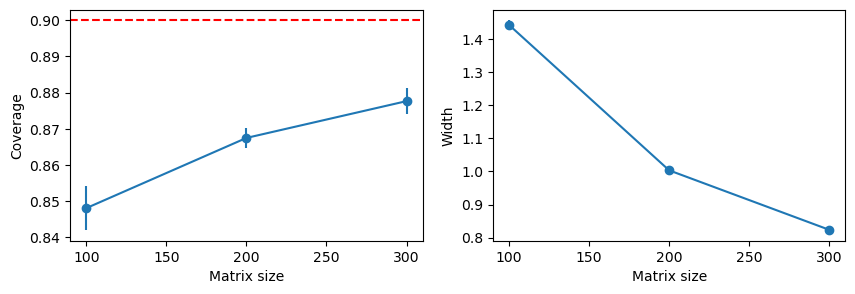

In [18]:
plt.rcParams["figure.figsize"] = (10,3)

plt.subplot(1, 2, 1)
plt.scatter(summary["n"], summary["Coverage"]["mean"])
plt.errorbar(summary["n"], summary["Coverage"]["mean"], 2*summary["Coverage"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.axhline(y=1-alpha, color='r', linestyle='--')
plt.xlabel("Matrix size")
plt.ylabel("Coverage")

plt.subplot(1, 2, 2)
plt.scatter(summary["n"], summary["Size"]["mean"])
plt.errorbar(summary["n"], summary["Size"]["mean"], 2*summary["Size"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.xlabel("Matrix size")
plt.ylabel("Width")

plt.show()

# Experiments with non-Gaussian noise (heavy tail)

In [19]:
# Fixed parameters
r_true = 5
r_guess = 5
p = 0.5        #proportion of observed
sigma = 1
kappa = 1
alpha = 0.1

# Varying parameters
n_list = [100]
df_list = [2,3,4,5,10]

def run_experiment(n, df, seed, method = 'ncvx'):
    # Parameters for this experiment
    n1 = n
    n2 = n
    
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma, df=df)
    M_true = M + E

    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)    
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=A, r=r_guess, alpha=alpha, 
                                                    method = method)
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    res = pd.DataFrame({"n":[n], "df":[df], "Seed":[seed], "Coverage": [result_coverage], "Size": [result_length]})
    return res

repetition = 100
results = pd.DataFrame({})
for seed in tqdm(range(repetition)):
    for n in n_list:
        for df in df_list:
            res_new = run_experiment(n, df, seed, method = 'cvx')
            results = pd.concat([results, res_new])

100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


In [20]:
summary = results.groupby(['n','df']).agg({'Seed':['count'],'Coverage':[np.mean,np.std], 'Size':[np.mean,np.std]}).reset_index()
summary

n  df  Seed  Coverage                Size          
           count      mean       std      mean       std
0  100   2   100  0.699165  0.078828  3.893615  2.398838
1  100   3   100  0.781854  0.033883  2.319869  0.140055
2  100   4   100  0.812844  0.012544  1.949884  0.089043
3  100   5   100  0.821602  0.013016  1.782323  0.040008
4  100  10   100  0.835917  0.010110  1.575884  0.020125

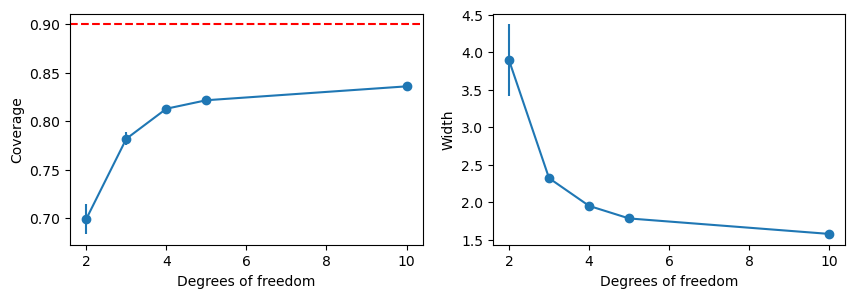

In [21]:
summary = summary[summary['n'] == 100] 

plt.rcParams["figure.figsize"] = (10,3)

plt.subplot(1, 2, 1)
plt.scatter(summary["df"], summary["Coverage"]["mean"])
plt.errorbar(summary["df"], summary["Coverage"]["mean"], 2*summary["Coverage"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.axhline(y=1-alpha, color='r', linestyle='--')
plt.xlabel("Degrees of freedom")
plt.ylabel("Coverage")

plt.subplot(1, 2, 2)
plt.scatter(summary["df"], summary["Size"]["mean"])
plt.errorbar(summary["df"], summary["Size"]["mean"], 2*summary["Size"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.xlabel("Degrees of freedom")
plt.ylabel("Width")

plt.show()

## Implementing with our data generating functions

Sampling from the noisy random orthogonal model... 



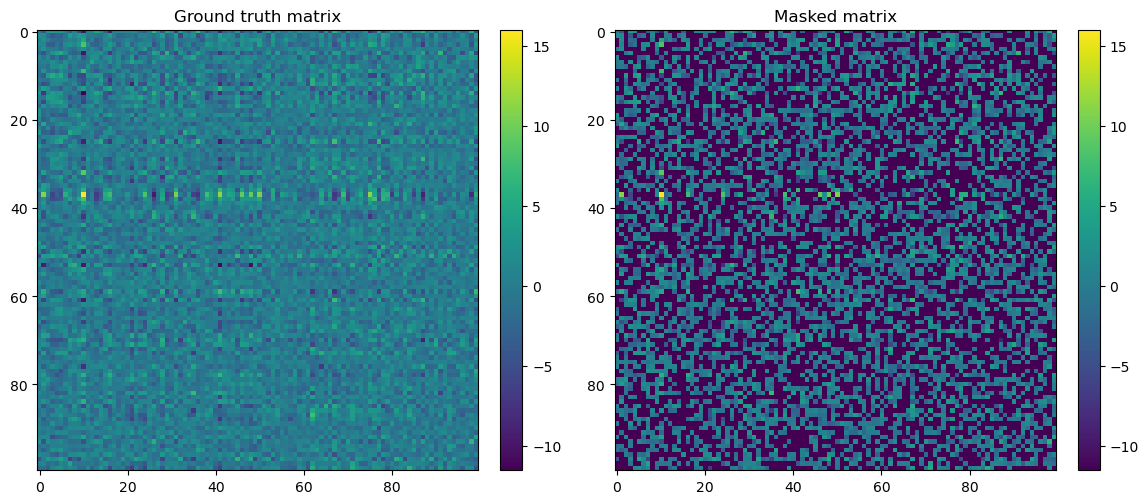

In [22]:
# Define experiment parameters
m, n, r = 100,100, 5
prob_obs = 0.5
random_state = 1
sigma = 1  #noise level

# Generate missing samples
sampler = RandomSampling(m, n)
mask = sampler.sample_observed(prop = prob_obs, fix_size = False, random_state=random_state)

# print('Sampling from the noiseless random factorization model... \n')
# RFM = RandomFactorizationModel(m ,n, r)
# _, _ ,M_rfm = RFM.sample_noiseless(random_state)

# masked_M_rfm = mask * M_rfm
# vmin, vmax = np.min(M_rfm), np.max(M_rfm)
# plot_before_after_mask(M_rfm, mask, vmin, vmax)

# print('\n'+'='*70+'\n')

# print('Sampling from the noiseless random orthogonal model... \n')
# ROM = RandomOrthogonalModel(m ,n, r)
# _,_,M_rom = ROM.sample_noiseless(random_state)

# masked_M_rom = mask * M_rom
# vmin, vmax = np.min(M_rom), np.max(M_rom)
# plot_before_after_mask(M_rom, mask, vmin, vmax)

# print('\n'+'='*70+'\n')

print('Sampling from the noisy random orthogonal model... \n')
ROM = RandomOrthogonalModel(m ,n, r)
_,_,_,M, M_rom_noisy = ROM.sample_noisy(random_state= random_state, sigma=sigma)

masked_M_rom = mask * M_rom_noisy
vmin, vmax = np.min(M_rom_noisy), np.max(M_rom_noisy)
plot_before_after_mask(M_rom_noisy, mask, vmin, vmax)

In [23]:
alpha = 0.1

# The data generating function goes back to the top
CI_left, CI_right = CI_method(M_obs = masked_M_rom, A = mask, r = r, alpha = alpha, method = 'ncvx')

# check
inside_CI = (M < CI_right) & (M > CI_left)
print(np.mean(inside_CI))  # if around (1-alpha), then good

#compute CI length
CI_length = CI_right - CI_left
print("Average CI Length:", CI_length.mean())

0.9452
Average CI Length: 1.9704269742409106


In [24]:
#NOTICE that here M is the matrix without noise

repetition = 10
alpha = 0.1
random_state = 1

results = []

for i in tqdm(range(repetition)):
    mask = (np.random.rand(n1, n2) < p).astype(int)
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_rom_noisy, mask=mask, r=r, alpha=alpha, 
                                                    method='cvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    results.append({"Coverage": result_coverage, "Size": result_length})
    
results_df = pd.DataFrame(results)

100%|██████████| 10/10 [00:00<00:00, 21.22it/s]


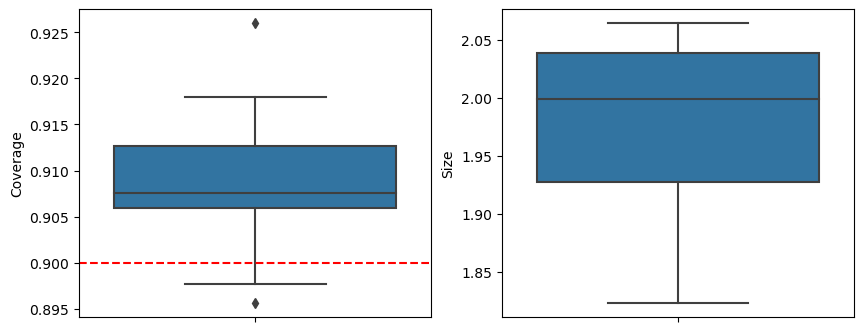

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_df, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_df, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

## Comformal inference based on this inference method

In [76]:
# Data generation
n1 = 100
n2 = 100
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
np.random.seed(1)

M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
E = generate_noise(n1, n2, sigma)
M_true = M + E

In [77]:
repetition = 100
alpha = 0.1
random_state = 1

results = pd.DataFrame({})

for i in tqdm(range(repetition)):
    sampler = RandomSampling(n1, n2)
    mask = sampler.sample_observed(prop = p, random_state=i)
    test_mask = np.ones_like(mask) - mask
    
    #because the code of the class has been changed.
    #now we have to specify the exact size of the calibration set first
    
    # calibration size
    calib_size = 500
    
    
    train_mask,calib_mask = sampler.sample_train_calib(mask=mask, 
                                                      calib_size=calib_size)
    
    res = run_single_experiment_conformalized_paper(matrix_noisy_unmasked=M_true,
                                                    M_noiseless= M,
                                                   train_mask=train_mask,
                                                   test_mask=test_mask,
                                                   calib_mask=calib_mask,
                                                   alpha=alpha,
                                                   r_guess = r)
    
    results = pd.concat([results, res])



100%|██████████| 100/100 [00:09<00:00, 11.08it/s]


In [100]:
# This block is to reproduce exactly the original method
repetition = 100
alpha = 0.1
random_state = 1

results_original = []

for i in tqdm(range(repetition)):
    mask = (np.random.rand(n1, n2) < p).astype(int)
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=mask, r=r, alpha=alpha, 
                                                    method='ncvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI[np.where(mask == 0)])
    
    CI_length = CI_right - CI_left
    result_length = CI_length[np.where(mask == 0)].mean()
    
    results_original.append({"Coverage": result_coverage, "Size": result_length})
    
results_original_df = pd.DataFrame(results_original)

100%|██████████| 100/100 [00:07<00:00, 12.58it/s]


In [81]:
results

,Coverage,Size,Quantile,Conformity_score,Alpha,Seed,Calib_size,Train_size
0,0.915167,2.555633,0.965709,2.116632,0.1,0,500,3500
0,0.896167,2.215627,0.942210,1.897289,0.1,0,500,3500
0,0.891333,2.377027,0.961300,2.067364,0.1,0,500,3500
0,0.902000,2.614897,0.974464,2.233199,0.1,0,500,3500
0,0.906000,2.391665,0.958384,2.037344,0.1,0,500,3500
...,...,...,...,...,...,...,...,...
0,0.930000,2.651631,0.977462,2.281168,0.1,0,500,3500
0,0.908333,2.366170,0.953113,1.987317,0.1,0,500,3500
0,0.897833,2.402410,0.954647,2.001361,0.1,0,500,3500
0,0.898667,2.363246,0.956450,2.018396,0.1,0,500,3500


In [82]:
results_original_df

,Coverage,Size
0,0.8370,1.744350
1,0.8480,1.719252
2,0.8619,1.685134
3,0.8745,1.777163
4,0.8757,1.805480
...,...,...
95,0.8577,1.725943
96,0.8433,1.680203
97,0.8676,1.758639
98,0.8725,1.774584


Conformal inference based on the variance estimation from the original paper 



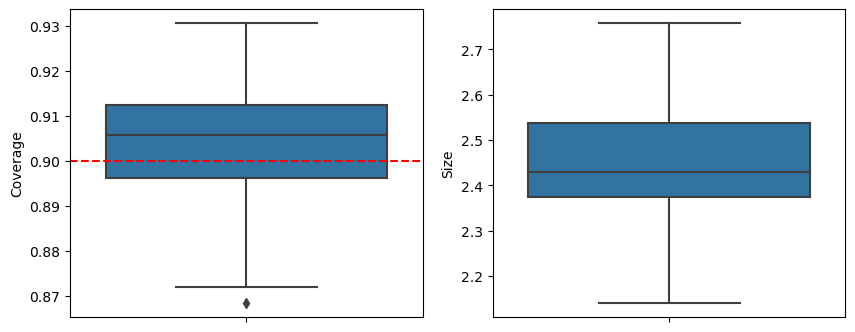



Original paper estimation 



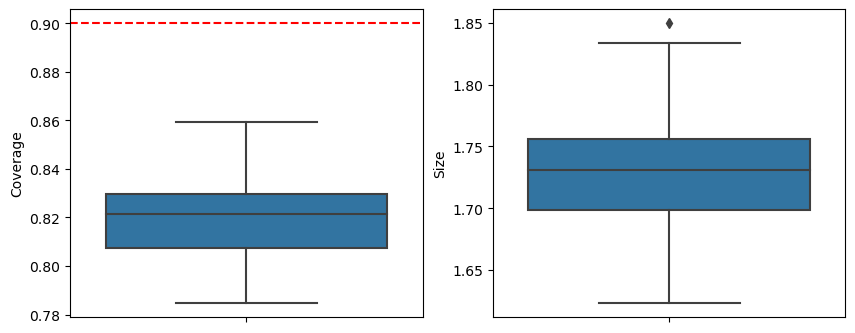

In [101]:
print('Conformal inference based on the variance estimation from the original paper \n')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

print('\n'+'='*70+'\n')

print('Original paper estimation \n')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_original_df, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_original_df, ax=ax2)
ax2.set(ylabel='Size')
plt.show()


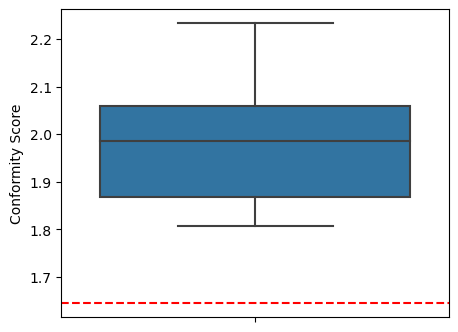

In [30]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 4))
sns.boxplot(y="Conformity_score", data=results, ax=ax1)
ax1.set(ylabel='Conformity Score')
ax1.axhline(norm.ppf(1 - alpha/2), ls='--', color="red")


plt.show()

## An extra comment: the original method indeed work differently on the masked entries and the observed entries

In [106]:
# This block is to reproduce exactly the original method
repetition = 100
alpha = 0.1
random_state = 1

results_original_on_missing = []
results_original_on_observed = []


for i in tqdm(range(repetition)):
    mask = (np.random.rand(n1, n2) < p).astype(int)
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=mask, r=r, alpha=alpha, 
                                                    method='ncvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    #coverage on missing entries
    result_coverage_missing = np.mean(inside_CI[np.where(mask == 0)])
    #coverage on observed entries
    result_coverage_observed = np.mean(inside_CI[np.where(mask == 1)])

    
    
    CI_length = CI_right - CI_left
    #interval size of missing entries
    result_length_missing = CI_length[np.where(mask == 0)].mean()
    #interval size of observed entries
    result_length_observed = CI_length[np.where(mask == 1)].mean()

    results_original_on_missing.append({"Coverage": result_coverage_missing, "Size": result_length_missing})
    results_original_on_observed.append({"Coverage": result_coverage_observed, "Size": result_length_observed})
    
results_original_on_missing_df = pd.DataFrame(results_original_on_missing)
results_original_on_observed_df = pd.DataFrame(results_original_on_observed)


100%|██████████| 100/100 [00:07<00:00, 12.56it/s]


Original paper estimation on observed entries 



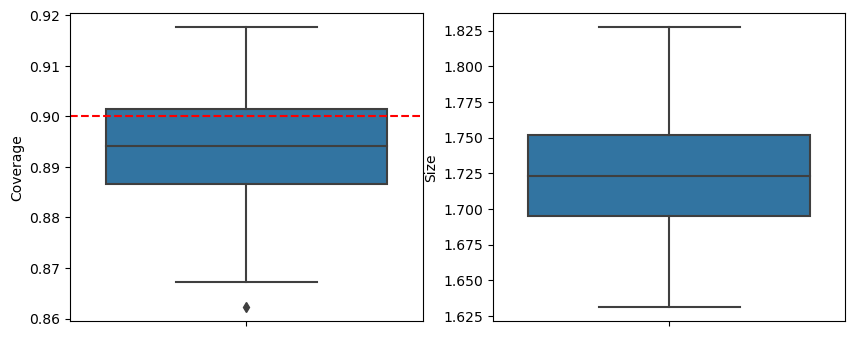



Original paper estimation on missing entries 



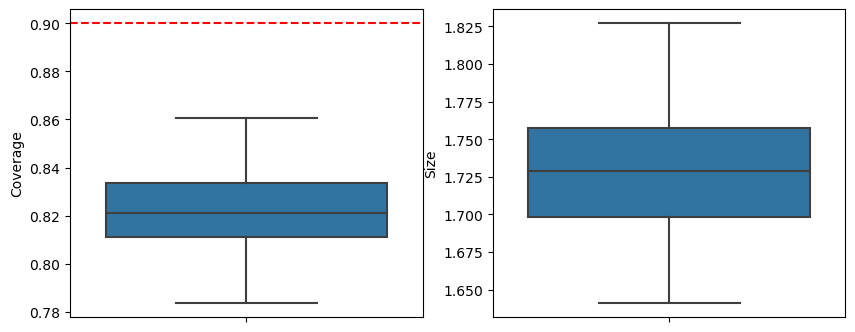

In [107]:
print('Original paper estimation on observed entries \n')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_original_on_observed_df, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_original_on_observed_df, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

print('\n'+'='*70+'\n')

print('Original paper estimation on missing entries \n')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_original_on_missing_df, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_original_on_missing_df, ax=ax2)
ax2.set(ylabel='Size')
plt.show()


## Now run with different matrix size (200x200) (the above is 100x100)

In [41]:
# Data generation
n1 = 200
n2 = 200
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
np.random.seed(1)

M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
E = generate_noise(n1, n2, sigma)
M_true = M + E

In [42]:
repetition = 10
calib_size = 500

alpha = 0.1
random_state = 1

results = pd.DataFrame({})

for i in tqdm(range(repetition)):
    sampler = RandomSampling(n1, n2)
    mask = sampler.sample_observed(prop = p, random_state=i)
    test_mask = np.ones_like(mask) - mask
    
    #because the code of the class has been changed.
    #now we have to specify the exact size of the calibration set first
    train_mask,calib_mask = sampler.sample_train_calib(mask=mask, 
                                                      calib_size=calib_size)
    
    res = run_single_experiment_conformalized_paper(matrix_noisy_unmasked=M_true,
                                                    M_noiseless= M,
                                                   train_mask=train_mask,
                                                   test_mask=test_mask,
                                                   calib_mask=calib_mask,
                                                   alpha=alpha,
                                                   r_guess = r)
    
    results = pd.concat([results, res])



100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


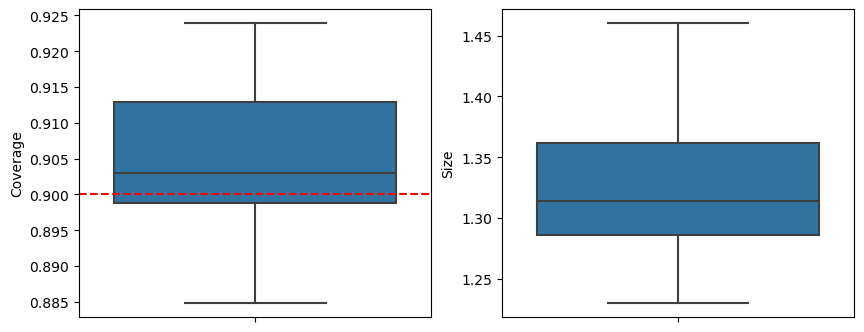

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

## More repetition?

In [47]:
# Data generation
n1 = 100
n2 = 100
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
np.random.seed(1)

M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
E = generate_noise(n1, n2, sigma)
M_true = M + E

In [48]:
repetition = 100
alpha = 0.1
random_state = 1
calib_size = 500


results = pd.DataFrame({})

for i in tqdm(range(repetition)):
    sampler = RandomSampling(n1, n2)
    mask = sampler.sample_observed(prop = p, random_state=i)
    test_mask = np.ones_like(mask) - mask
    
    #because the code of the class has been changed.
    #now we have to specify the exact size of the calibration set first
    train_mask,calib_mask = sampler.sample_train_calib(mask=mask, 
                                                      calib_size=calib_size)
    
    res = run_single_experiment_conformalized_paper(matrix_noisy_unmasked=M_true,
                                                    M_noiseless= M,
                                                   train_mask=train_mask,
                                                   test_mask=test_mask,
                                                   calib_mask=calib_mask,
                                                   alpha=alpha,
                                                   r_guess = r)
    
    results = pd.concat([results, res])



100%|██████████| 100/100 [00:09<00:00, 10.77it/s]


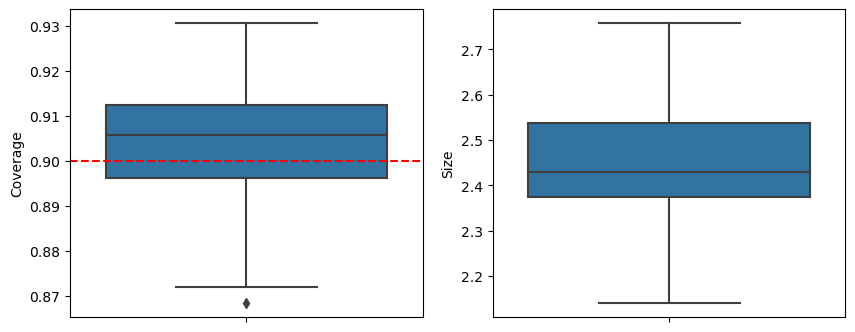

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

### Changing Matrix Size

In [64]:
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
alpha = 0.1


n_list = [80, 90, 100, 150, 200, 250, 300, 350, 400, 450, 500]
# n_list = [100, 150, 200, 250, 300, 350, 400, 450, 500] #calibration size is fixed and cannot exceed the matrix size
repetition = 20
calib_size = 500



results = pd.DataFrame({})

for n in n_list:
    n1 = n
    n2 = n
    np.random.seed(n)
    
    M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
    E = generate_noise(n1, n2, sigma)
    M_true = M + E

    
    for i in tqdm(range(repetition)):
        sampler = RandomSampling(n1, n2)
        mask = sampler.sample_observed(prop = p, random_state=i)
        test_mask = np.ones_like(mask) - mask

        #because the code of the class has been changed.
        #now we have to specify the exact size of the calibration set first
        train_mask,calib_mask = sampler.sample_train_calib(mask=mask, 
                                                          calib_size=calib_size)

        res = run_single_experiment_conformalized_paper(matrix_noisy_unmasked=M_true,
                                                        M_noiseless= M,
                                                       train_mask=train_mask,
                                                       test_mask=test_mask,
                                                       calib_mask=calib_mask,
                                                       alpha=alpha,
                                                       r_guess = r)

        res['n']=[n]
        results = pd.concat([results, res])

100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


In [65]:
results

,Coverage,Size,Quantile,Conformity_score,Alpha,Seed,Calib_size,Train_size,n
0,0.914323,3.343671,0.969632,2.165263,0.1,0,500,2060,80
0,0.918229,3.699598,0.976207,2.260449,0.1,0,500,2060,80
0,0.908333,3.230725,0.953208,1.988182,0.1,0,500,2060,80
0,0.913021,3.512813,0.984785,2.427216,0.1,0,500,2060,80
0,0.881510,3.069930,0.950577,1.964922,0.1,0,500,2060,80
...,...,...,...,...,...,...,...,...,...
0,0.892487,0.728435,0.904217,1.665651,0.1,0,500,99500,500
0,0.894367,0.734862,0.906695,1.678218,0.1,0,500,99500,500
0,0.904487,0.749775,0.912279,1.707546,0.1,0,500,99500,500
0,0.912233,0.774386,0.922069,1.762816,0.1,0,500,99500,500


In [66]:
summary_flat = results.groupby(['n']).agg({'Conformity_score':[np.mean,np.std]}).reset_index()
summary_flat

n Conformity_score          
                    mean       std
0    80         2.189981  0.166182
1    90         2.108186  0.195212
2   100         2.010079  0.103569
3   150         1.876593  0.085169
4   200         1.798422  0.073631
5   250         1.777469  0.081315
6   300         1.758102  0.056318
7   350         1.748692  0.061082
8   400         1.732970  0.061816
9   450         1.733651  0.075647
10  500         1.724710  0.075219

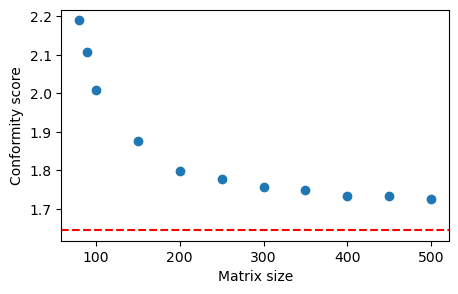

In [67]:
plt.rcParams["figure.figsize"] = (5,3)

plt.subplot(1, 1, 1)
plt.scatter(summary_flat["n"], summary_flat["Conformity_score"]["mean"])
plt.axhline(y=norm.ppf(1 - alpha/2), color='r', linestyle='--')
plt.xlabel("Matrix size")
plt.ylabel("Conformity score")

plt.show()